# Full FCL-Net

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, LSTM, Dense, Flatten, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# taxi data
df = pd.read_parquet(r"C:\Users\justu\OneDrive\Desktop\Thesis\2009 taxi data\4. Taxi Data Square Grids and Weather\final.parquet")
df = df[['Trip_Pickup_DateTime', 'grid_cell_id', 'demand', 'time_travel_rate',
       'Trip_Distance', 'weekdays', 'hour', 'time-of-day', 'temp',
       'humidity', 'windspeed', 'visibility', 'conditions']]
print(df.head(1))
print(df.info())

  Trip_Pickup_DateTime  grid_cell_id  demand  time_travel_rate  Trip_Distance  \
0           2009-01-01             1     0.0               0.0            0.0   

   weekdays  hour  time-of-day  temp  humidity  windspeed  visibility  \
0         0     0            0  -7.6     53.66       29.0        16.0   

         conditions  
0  Partially cloudy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3784320 entries, 0 to 3784319
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Trip_Pickup_DateTime  datetime64[ns]
 1   grid_cell_id          int64         
 2   demand                float64       
 3   time_travel_rate      float64       
 4   Trip_Distance         float64       
 5   weekdays              int64         
 6   hour                  int32         
 7   time-of-day           int64         
 8   temp                  float64       
 9   humidity              float64       
 10  windspeed             fl

In [3]:
# Convert all numeric columns to float32
float_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
df[float_cols] = df[float_cols].astype('float32')

# Split into training and testing sets (70-30 split)
split_date = df['Trip_Pickup_DateTime'].quantile(0.7)
df_train = df[df['Trip_Pickup_DateTime'] <= split_date]
df_test = df[df['Trip_Pickup_DateTime'] > split_date]

# Normalize continuous features
scaler = MinMaxScaler()
columns_to_scale = ['demand', 'time_travel_rate', 'temp', 'humidity', 'windspeed', 'visibility']
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

# One-hot encode categorical features
df_train = pd.get_dummies(df_train, columns=['conditions'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['conditions'], drop_first=True)

# Ensure test and train columns align after one-hot encoding
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0
df_test = df_test[df_train.columns]

C:\Users\justu\AppData\Local\Temp\ipykernel_12528\2017841055.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
C:\Users\justu\AppData\Local\Temp\ipykernel_12528\2017841055.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])


In [4]:
# Spatio-temporal and temporal feature selection
spatio_temporal_features = ['demand', 'time_travel_rate']
temporal_features = ['weekdays', 'hour', 'time-of-day', 'temp', 'humidity', 'windspeed', 'visibility'] + \
                    [col for col in df_train if col.startswith('conditions_')]

time_steps = 8  # Look-back window
num_cells = 432  # Total grid cells

def prepare_tensors(df, spatio_features, temp_features, num_cells, time_steps):
    # Reshape spatio-temporal features
    X_st = df[spatio_features].values.reshape(-1, num_cells, len(spatio_features)).astype('float32')
    X_temp = df[temp_features].values.reshape(-1, len(temp_features)).astype('float32')
    y = df['demand'].values.reshape(-1, num_cells).astype('float32')  # Output (future demand)
    
    def create_time_windows(X_st, X_temp, y, time_steps):
        X_st_windows, X_temp_windows, y_windows = [], [], []
        for i in range(len(X_st) - time_steps):
            X_st_windows.append(X_st[i:i + time_steps])
            X_temp_windows.append(X_temp[i:i + time_steps])
            y_windows.append(y[i + time_steps])
        return np.array(X_st_windows), np.array(X_temp_windows), np.array(y_windows)
    
    return create_time_windows(X_st, X_temp, y, time_steps)

# Prepare tensors for training and testing
X_st_train, X_temp_train, y_train = prepare_tensors(df_train, spatio_temporal_features, temporal_features, num_cells, time_steps)
X_st_test, X_temp_test, y_test = prepare_tensors(df_test, spatio_temporal_features, temporal_features, num_cells, time_steps)

# Add channel dimension and ensure the correct order of dimensions
X_st_train = np.expand_dims(X_st_train, axis=-2)  # Adds a channel dimension at the correct position
X_st_test = np.expand_dims(X_st_test, axis=-2)

print("X_st_train shape:", X_st_train.shape)  # Should be (batch_size, time_steps, grid_cells, 1, features)

X_st_train shape: (6124, 8, 432, 1, 2)


In [5]:
print("X_st_train shape: ", X_st_train.shape)  # Should be (batch_size, 8, 432, 1, 2)
print("X_temp_train shape: ", X_temp_train.shape)  # Should be (batch_size, 8, 17)
print("y_train shape: ", y_train.shape)  # Should be (batch_size, 432)

X_st_train shape:  (6124, 8, 432, 1, 2)
X_temp_train shape:  (6124, 8, 17)
y_train shape:  (6124, 432)


In [6]:
# Define input shapes
spatial_input_shape = (time_steps, num_cells, 1, len(spatio_temporal_features))  # ConvLSTM requires 5D
temporal_input_shape = (time_steps, len(temporal_features))  # Temporal features

# Spatio-Temporal Input
spatial_input = Input(shape=spatial_input_shape)
spatial_conv_lstm = ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=False)(spatial_input)
spatial_flatten = Flatten()(spatial_conv_lstm)

# Temporal Input
temporal_input = Input(shape=temporal_input_shape)
temporal_lstm = LSTM(64)(temporal_input)

# Fusion Layer
fusion = concatenate([spatial_flatten, temporal_lstm])
fusion_dense = Dense(64, activation='relu')(fusion)

# Output Layer
output = Dense(num_cells, activation='linear')(fusion_dense)

# Model Definition
model = Model(inputs=[spatial_input, temporal_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 432, 1, 2)]       0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 432, 1, 64)           17152     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 8, 17)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 27648)                0         ['conv_lstm2d[0][0]']         
                                                                                              

In [8]:
import os

# Directory to save the best model
os.makedirs("models", exist_ok=True)

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath="models/best_fcl_net_model.h5",  # Save the best model here
    monitor='val_loss',                      # Monitor validation loss
    save_best_only=True,                     # Save only the best model
    mode='min',                              # Minimize the validation loss
    verbose=1
)

In [11]:
# Train the model
history = model.fit(
    [X_st_train, X_temp_train], 
    y_train, 
    validation_split=0.2, 
    epochs=100, 
    batch_size=32,
    callbacks=[checkpoint_callback]  
)

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 3.2006e-04 - mae: 0.0063
Epoch 1: val_loss improved from inf to 0.00019, saving model to models\best_fcl_net_model.h5
154/154 [==============================] - 75s 485ms/step - loss: 3.2006e-04 - mae: 0.0063 - val_loss: 1.9024e-04 - val_mae: 0.0048
Epoch 2/100


c:\Users\justu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


154/154 [==============================] - ETA: 0s - loss: 1.7587e-04 - mae: 0.0047
Epoch 2: val_loss improved from 0.00019 to 0.00015, saving model to models\best_fcl_net_model.h5
154/154 [==============================] - 74s 483ms/step - loss: 1.7587e-04 - mae: 0.0047 - val_loss: 1.5045e-04 - val_mae: 0.0045
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 1.3632e-04 - mae: 0.0042
Epoch 3: val_loss improved from 0.00015 to 0.00010, saving model to models\best_fcl_net_model.h5
154/154 [==============================] - 74s 482ms/step - loss: 1.3632e-04 - mae: 0.0042 - val_loss: 1.0434e-04 - val_mae: 0.0039
Epoch 4/100
153/154 [============================>.] - ETA: 0s - loss: 1.0829e-04 - mae: 0.0036
Epoch 4: val_loss improved from 0.00010 to 0.00009, saving model to models\best_fcl_net_model.h5
154/154 [==============================] - 75s 485ms/step - loss: 1.0827e-04 - mae: 0.0036 - val_loss: 9.4109e-05 - val_mae: 0.0035
Epoch 5/100
154/154 [================

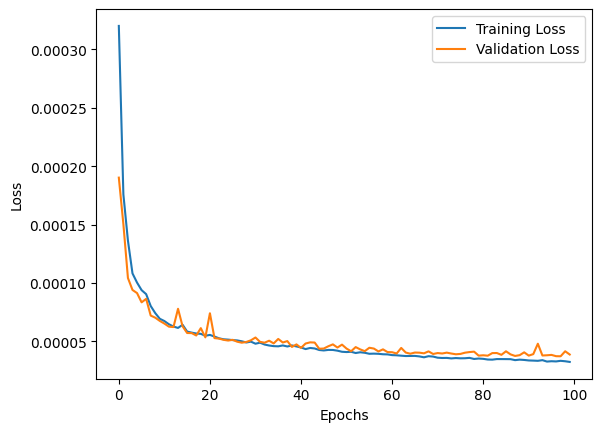

In [12]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("models/best_fcl_net_model.h5")

In [15]:
# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate([X_st_test, X_temp_test], y_test, verbose=1)

print(f"Best Model Test Loss: {test_loss}")
print(f"Best Model Test MAE: {test_mae}")

82/82 [==============================] - 9s 107ms/step - loss: 6.2990e-05 - mae: 0.0019
Best Model Test Loss: 6.299008964560926e-05
Best Model Test MAE: 0.0018636644817888737


In [17]:
# Predict on the test set
y_pred = best_model.predict([X_st_test, X_temp_test])

82/82 [==============================] - 9s 111ms/step


In [20]:
# Extract scaler parameters for the 'demand' column (assumed to be the first in columns_to_scale)
demand_min = scaler.min_[0]  # Minimum value for 'demand'
demand_scale = scaler.scale_[0]  # Scale for 'demand'

# Denormalize predictions
y_pred_denormalized = (y_pred * (1 / demand_scale)) + demand_min

# Denormalize test values
y_test_denormalized = (y_test * (1 / demand_scale)) + demand_min

In [22]:
import numpy as np

# Define a function to calculate MAPE
def compute_mape(actual, predicted):
    # Filter for demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]
    
    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

# Flatten the test and prediction arrays for comparison
y_test_flat = y_test_denormalized.flatten()
y_pred_flat = y_pred_denormalized.flatten()

# Calculate MAPE
mape = compute_mape(y_test_flat, y_pred_flat)

# Display the MAPE
if not np.isnan(mape):
    print(f"MAPE for demand values >= 10: {mape:.2f}%")
else:
    print("No demand values >= 10 in the dataset.")

MAPE for demand values >= 10: 21.65%


Aggregated Actual Demand (sample): [20173. 17565. 15757. 13820. 10917.]
Aggregated Predicted Demand (sample): [17150.16  20275.668 15513.193 13083.552 10236.998]


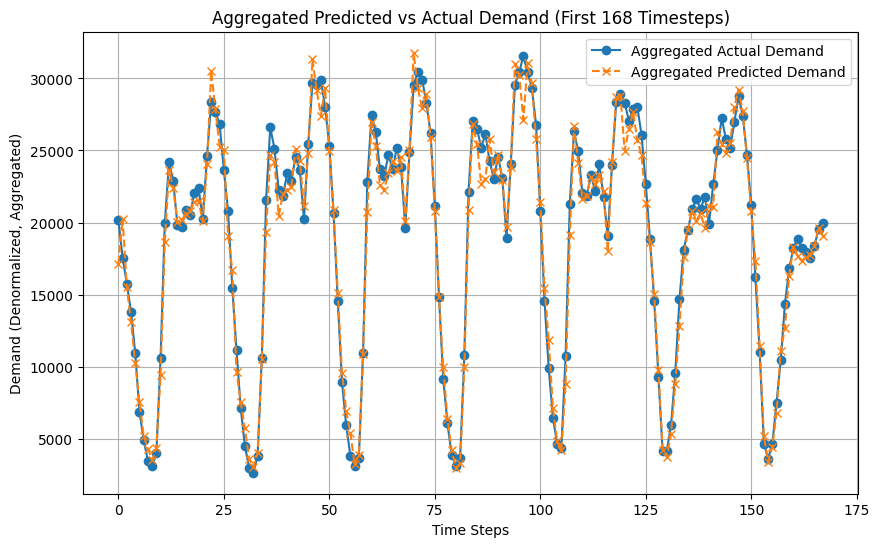

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Select a specific time frame for comparison
time_steps = 168  # Number of time steps to visualize

# Aggregate demand across all grid cells for the first 168 timesteps
# Sum over grid cells (axis=1) for each timestep
actual_demand_aggregated = np.sum(y_test_denormalized[:time_steps], axis=1)
predicted_demand_aggregated = np.sum(y_pred_denormalized[:time_steps], axis=1)

# Ensure the values are properly updated
print("Aggregated Actual Demand (sample):", actual_demand_aggregated[:5])
print("Aggregated Predicted Demand (sample):", predicted_demand_aggregated[:5])

# Plot aggregated actual vs predicted demand
plt.figure(figsize=(10, 6))
plt.plot(actual_demand_aggregated, label="Aggregated Actual Demand", linestyle='-', marker='o')
plt.plot(predicted_demand_aggregated, label="Aggregated Predicted Demand", linestyle='--', marker='x')

plt.title("Aggregated Predicted vs Actual Demand (First 168 Timesteps)")
plt.xlabel("Time Steps")
plt.ylabel("Demand (Denormalized, Aggregated)")
plt.legend()
plt.grid()
plt.show()

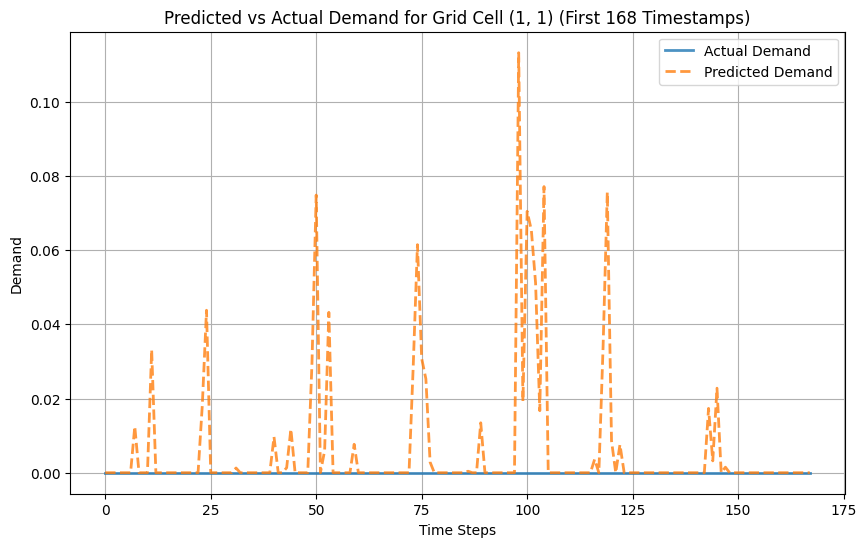

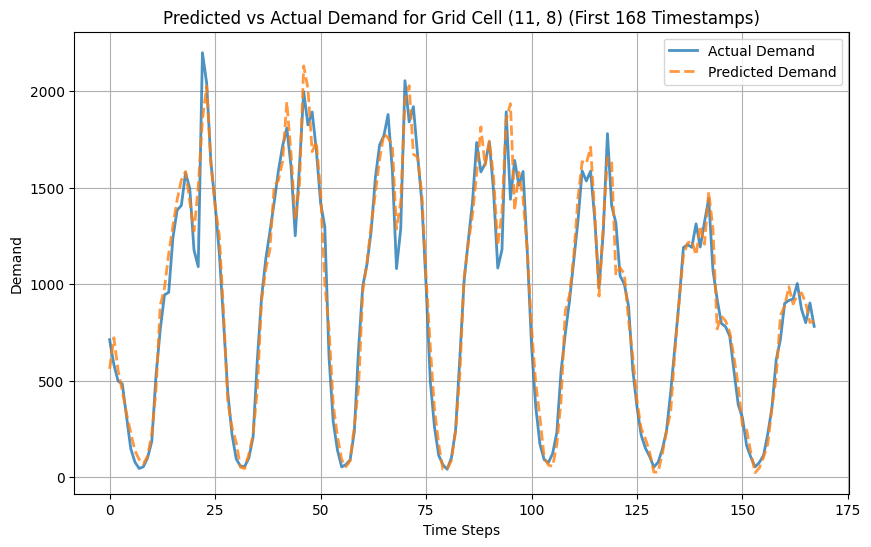

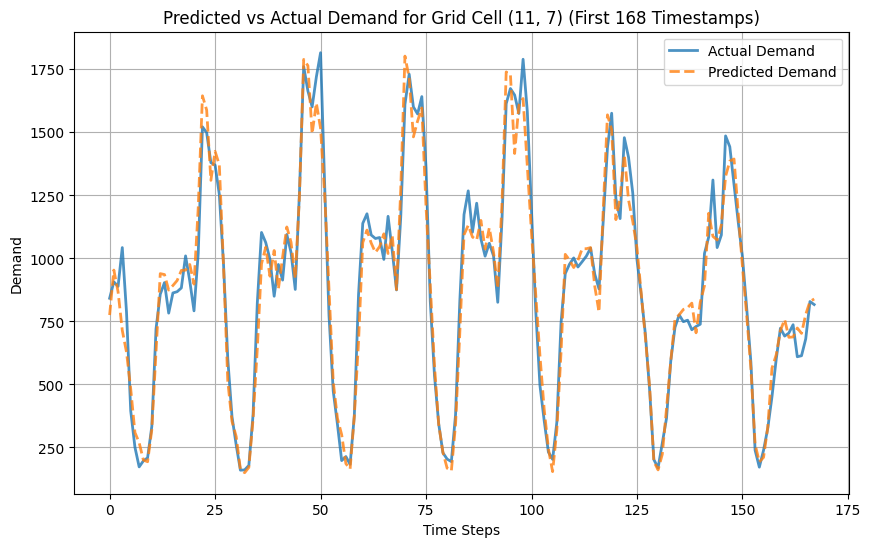

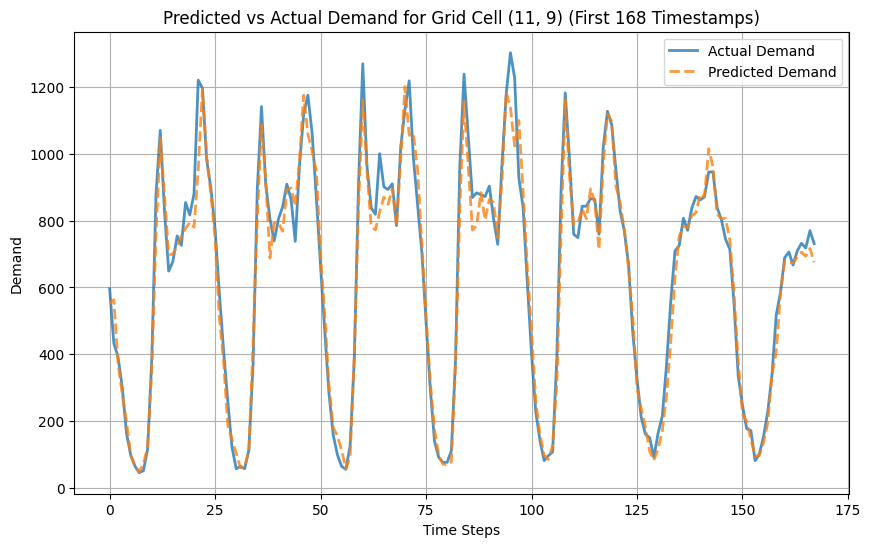

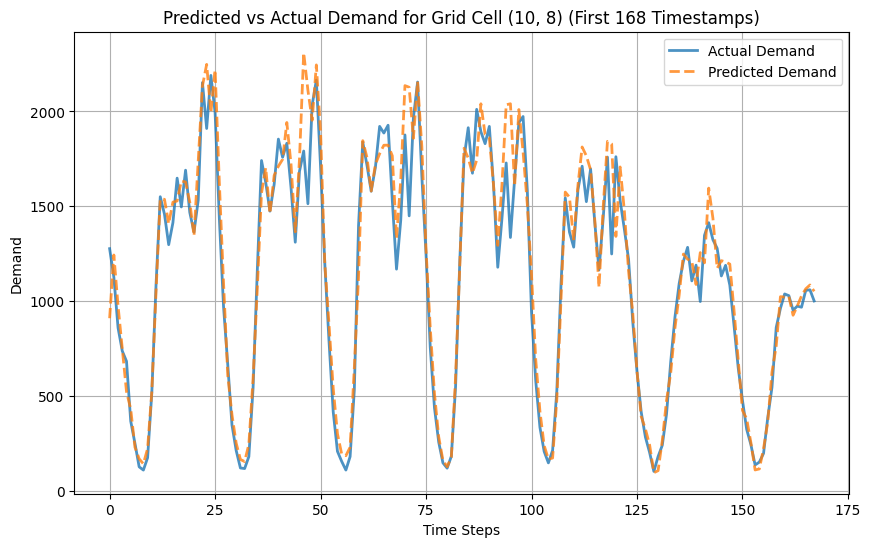

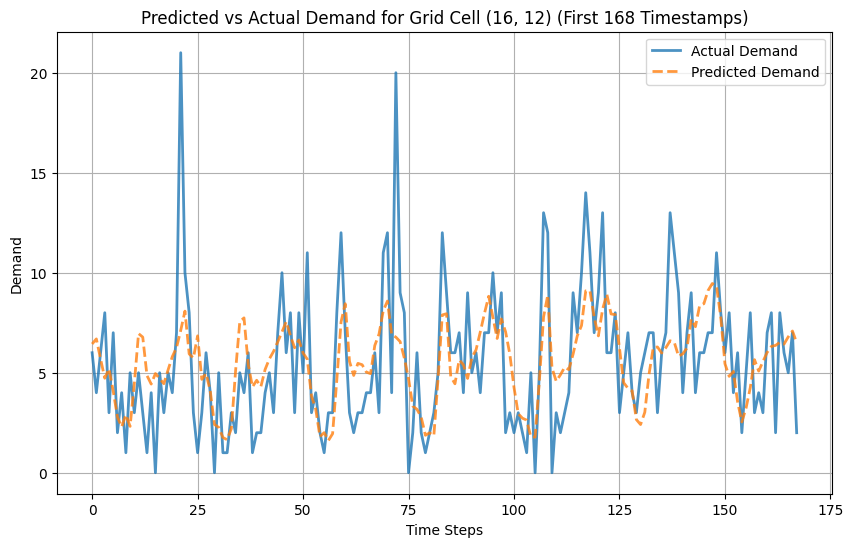

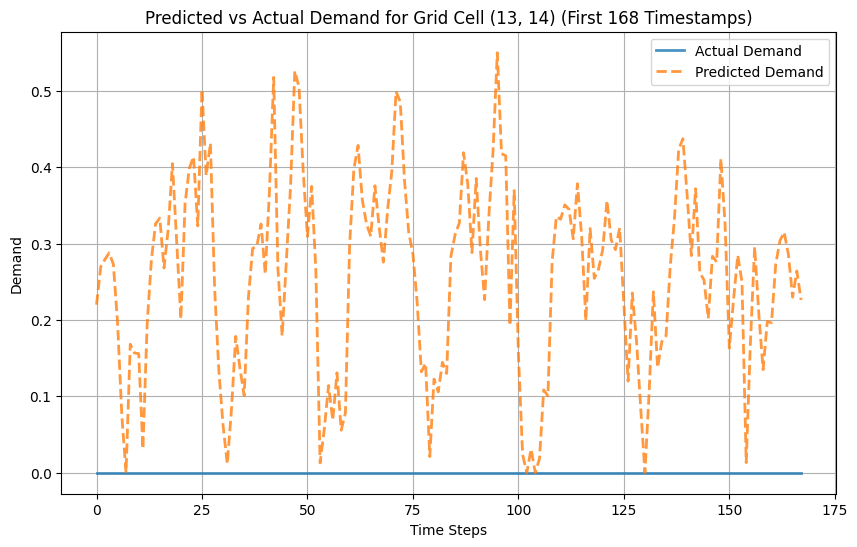

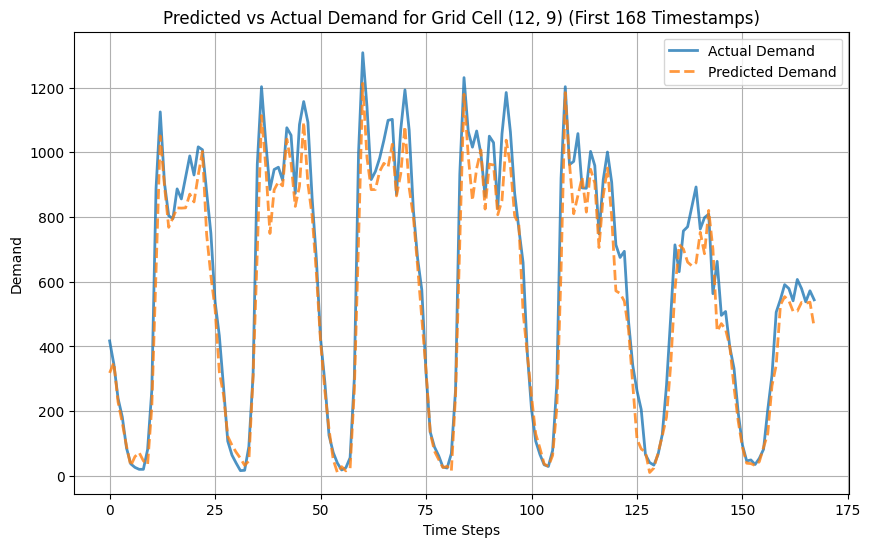

In [28]:
import matplotlib.pyplot as plt

# Flatten the test and prediction arrays for comparison
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_cells)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_cells)

# Extract scaler parameters for the 'demand' column
demand_min = scaler.min_[0]  # Minimum value for 'demand'
demand_scale = scaler.scale_[0]  # Scale for 'demand'

# Denormalize predictions and test data
y_test_original = (y_test_flat * (1 / demand_scale)) + demand_min
y_pred_original = (y_pred_flat * (1 / demand_scale)) + demand_min

import numpy as np
import matplotlib.pyplot as plt

# Define grid dimensions
num_rows = 27
num_cols = 16
num_cells = num_rows * num_cols  # Total grid cells

# Define grid cells to analyze (row, column format)
grid_cells = [(1, 1), (11, 8), (11, 7), (11, 9), (10, 8), (16, 12), (13, 14), (12, 9)]  # Example grid cell coordinates

# Restrict to the first 168 timestamps
time_steps = 168
y_test_original = y_test_original[:time_steps]
y_pred_original = y_pred_original[:time_steps]

# Clamp FCL-Net predictions to ensure non-negative values
y_pred_original = np.clip(y_pred_original, a_min=0, a_max=None)  # Set minimum to 0

# Loop through each grid cell
for grid_row, grid_col in grid_cells:
    # Calculate the corresponding grid cell index
    grid_cell = grid_row * num_cols + grid_col

    # Extract actuals and predictions for the grid cell
    if grid_cell >= y_test_original.shape[1]:
        print(f"Grid cell ({grid_row}, {grid_col}) is out of bounds. Skipping.")
        continue

    actuals = y_test_original[:, grid_cell]
    preds = y_pred_original[:, grid_cell]

    # Plot predicted vs actual for this grid cell
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Demand", alpha=0.8, linewidth=2)
    plt.plot(preds, label="Predicted Demand", alpha=0.8, linestyle="dashed", linewidth=2)
    plt.title(f"Predicted vs Actual Demand for Grid Cell ({grid_row}, {grid_col}) (First 168 Timestamps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid()
    plt.show()

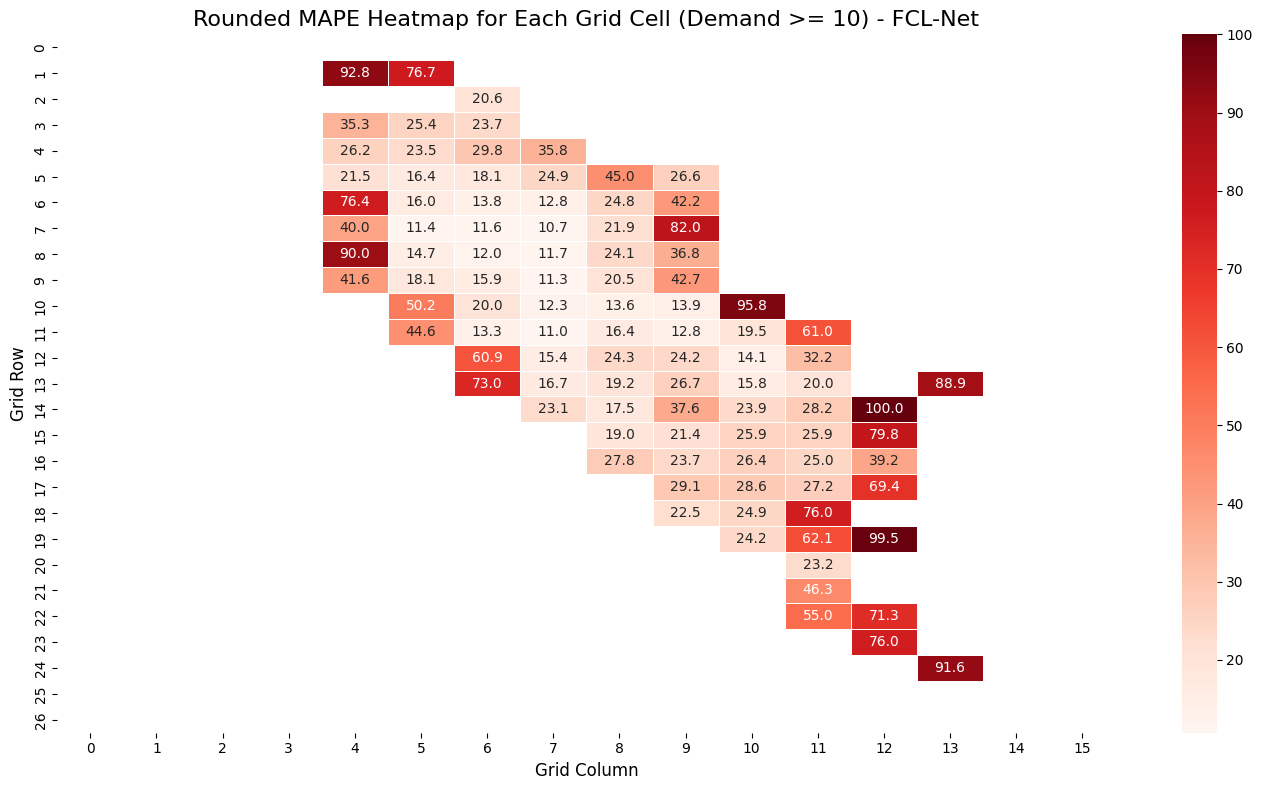

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clamp predictions to ensure non-negative values
y_pred = np.clip(y_pred, a_min=0, a_max=None)

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(-1, num_rows * num_cols)  # First 168 timestamps
y_pred_flat = y_pred.reshape(-1, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = (y_test_flat * (1 / scaler.scale_[0])) + scaler.min_[0]
y_pred_original = (y_pred_flat * (1 / scaler.scale_[0])) + scaler.min_[0]

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Filter out grid cells with zero total demand
valid_cells = total_demand > 0

# Compute MAPE for each valid grid cell
def compute_mape(actual, predicted):
    # Filter for demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

mape_values = []
for grid_cell in range(num_rows * num_cols):
    if valid_cells[grid_cell]:
        actuals = y_test_original[:, grid_cell]
        preds = y_pred_original[:, grid_cell]
        mape = compute_mape(actuals, preds)
        mape_values.append(mape)
    else:
        mape_values.append(np.nan)  # Assign NaN for invalid cells

# Reshape MAPE values into a 2D grid
mape_grid = np.array(mape_values).reshape(num_rows, num_cols)

# Round MAPE values for better visualization
mape_grid_rounded = np.round(mape_grid, 1)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(mape_grid_rounded, annot=True, fmt=".1f", cmap="Reds", cbar=True, linewidths=0.5)
plt.title("Rounded MAPE Heatmap for Each Grid Cell (Demand >= 10) - FCL-Net", fontsize=16)
plt.xlabel("Grid Column", fontsize=12)
plt.ylabel("Grid Row", fontsize=12)
plt.tight_layout()
plt.show()

    demand_group       MAPE
0    Weakest 25%  91.765191
1        25%-50%  55.641548
2        50%-75%  27.772152
3  Strongest 25%  15.853337


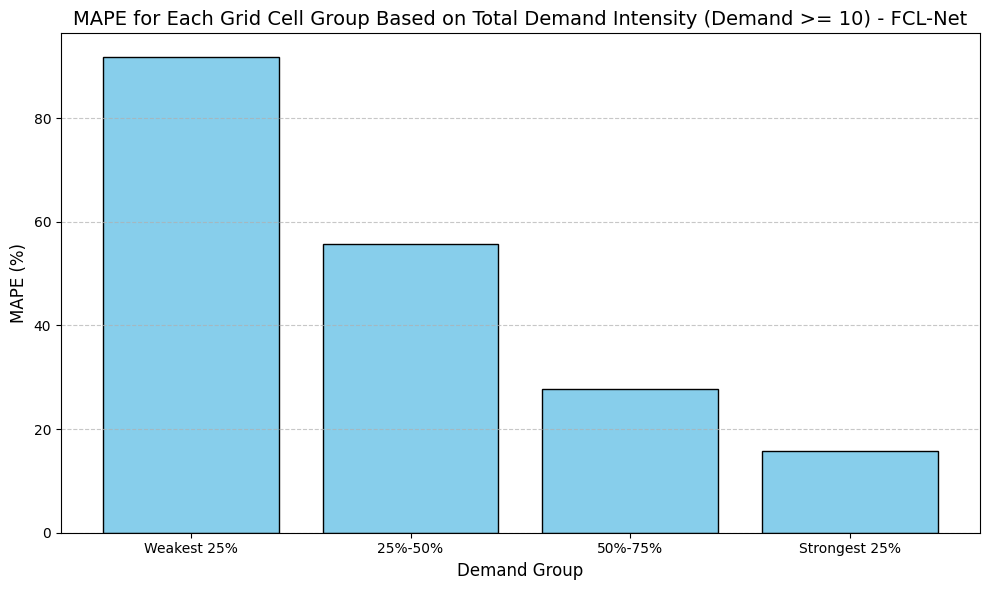

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clamp predictions to ensure non-negative values
y_pred = np.clip(y_pred, a_min=0, a_max=None)

y_test_flat = y_test.reshape(-1, num_rows * num_cols)  # Shape: (time_steps, num_cells)
y_pred_flat = y_pred.reshape(-1, num_rows * num_cols)  # Shape: (time_steps, num_cells)

# Inverse transform to original scale for 'demand'
demand_min = scaler.min_[0]  # Minimum value for 'demand'
demand_scale = scaler.scale_[0]  # Scale for 'demand'

y_test_original = (y_test_flat * (1 / demand_scale)) + demand_min
y_pred_original = (y_pred_flat * (1 / demand_scale)) + demand_min

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Create a DataFrame to hold grid cell data
grid_data = pd.DataFrame({
    "grid_cell_id": range(num_rows * num_cols),
    "total_demand": total_demand
})

# Exclude cells with zero total demand
grid_data = grid_data[grid_data["total_demand"] > 0]

# Divide remaining cells into 4 groups based on total demand (quartiles)
grid_data["demand_group"] = pd.qcut(
    grid_data["total_demand"], 
    4, 
    labels=["Weakest 25%", "25%-50%", "50%-75%", "Strongest 25%"]
)

# Update the MAPE calculation function to include only demand values >= 10
def compute_mape(actual, predicted):
    # Filter for actual demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

# Compute MAPE for each grid cell
mape_values = []
for grid_cell in grid_data["grid_cell_id"]:
    actuals = y_test_original[:, grid_cell]
    preds = y_pred_original[:, grid_cell]
    mape = compute_mape(actuals, preds)
    mape_values.append(mape)

# Add MAPE values to grid_data
grid_data["MAPE"] = mape_values

# Drop NaN MAPE values (if any grid cells had no valid data)
grid_data = grid_data.dropna(subset=["MAPE"])

# Calculate average MAPE for each group
grouped_mape = grid_data.groupby("demand_group")["MAPE"].mean().reset_index()

# Display the results
print(grouped_mape)

# Plot the MAPE for each group
plt.figure(figsize=(10, 6))
plt.bar(grouped_mape["demand_group"], grouped_mape["MAPE"], color="skyblue", edgecolor="black")
plt.title("MAPE for Each Grid Cell Group Based on Total Demand Intensity (Demand >= 10) - FCL-Net", fontsize=14)
plt.xlabel("Demand Group", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

----------------------------------

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(f"RMSE: {rmse}")

RMSE: 0.008775419555604458


In [11]:
from sklearn.metrics import mean_absolute_error

# MAE
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
print(f"MAE: {mae}")

MAE: 0.0027121449820697308


In [14]:
# Reshape y_test and y_pred to match scaler's input format
y_test_reshaped = y_test.flatten().reshape(-1, 1)  # 2D array for inverse_transform
y_pred_reshaped = y_pred.flatten().reshape(-1, 1)  # 2D array for inverse_transform

# Create placeholders for other features (zeros, as they aren't used in evaluation)
num_other_features = scaler.n_features_in_ - 1  # Number of other features used in scaler
placeholder = np.zeros((y_test_reshaped.shape[0], num_other_features))

# Combine demand with placeholders for all features
y_test_combined = np.hstack((y_test_reshaped, placeholder))
y_pred_combined = np.hstack((y_pred_reshaped, placeholder))

# Perform inverse transform to back-normalize
y_test_back_normalized = scaler.inverse_transform(y_test_combined)[:, 0]  # Only extract demand column
y_pred_back_normalized = scaler.inverse_transform(y_pred_combined)[:, 0]

In [15]:
# Mask for demand values >= 10
mask = y_test_back_normalized >= 10

# Apply the mask to filter values
y_test_masked = y_test_back_normalized[mask]
y_pred_masked = y_pred_back_normalized[mask]

# Avoid division by zero in MAPE
mape = np.mean(np.abs((y_test_masked - y_pred_masked) / y_test_masked)) * 100
print(f"MAPE (demand >= 10): {mape:.2f}%")

MAPE (demand >= 10): 24.23%
